# Part A

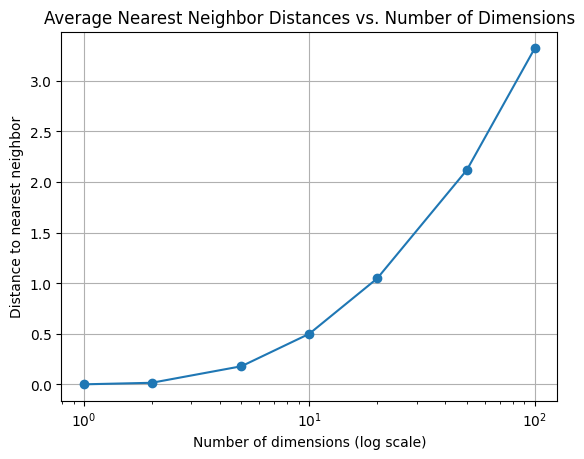

In [27]:
##%pip install torch
import numpy as np
import matplotlib.pyplot as plt
import torch

m = 1000 #number of points
n = [1,2,5,10,20,50,100] #number of dimensions
records = [[] for _ in range(len(n))]
minimum_distances= [[] for _ in range(len(n))]

def generate_points(num_dimensions,num_points):
    #batch = [[] for _ in range(m)]
    #for i in range(num_points):
        #batch[i] = np.random.uniform(0, 1, num_dimensions)
    batch = torch.rand(num_points, num_dimensions)
    return batch
        


for i in range(len(n)):
    records[i]=generate_points(n[i], m)



for i in range(len(n)):
    minimum_distances[i] = np.zeros(m)
    for j in range(m):
        distances = np.linalg.norm(records[i] - records[i][j], axis=1) #compute all distances to point j (including self)  
        distances = np.delete(distances, j) #remove the distance to self number; when commenting this out, we see that the above line works correctly as it calculates distances from self to self as 0
        minimum_distances[i][j] = np.min(distances) #record the distance to nearest neighbor
    
average_minimum_distances = [np.mean(minimum_distances[i]) for i in range(len(n))]

#print(average_minimum_distances)

plt.plot(n, average_minimum_distances, marker='o')
plt.xscale('log') #To use a logarithmic scale for the x-axis and separate points more clearly
plt.xlabel('Number of dimensions (log scale)')
plt.ylabel('Distance to nearest neighbor')
plt.title('Average Nearest Neighbor Distances vs. Number of Dimensions')
plt.grid(True)
plt.show()


# Part B

In [ ]:
TRAIN_PATH = "/workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz"

In [58]:
# Data Investigation
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
TRAIN_PATH = "/workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz"
dataset = ds.dataset(TRAIN_PATH, format='csv')
scanner = dataset.scanner(batch_size=10, use_threads=True)
first_batch = next(iter(scanner.to_batches()))
table = pa.Table.from_batches([first_batch])
df = table.to_pandas()
print('First 10 rows:')
print(df)
print("Column names:")
print(df.columns.tolist())

First 10 rows:
             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   
5  1.000072e+19      0  14102100  1005           0  d6137915    bb1ef334   
6  1.000072e+19      0  14102100  1005           0  8fda644b    25d4cfcd   
7  1.000092e+19      0  14102100  1005           1  e151e245    7e091613   
8  1.000095e+19      1  14102100  1005           0  1fbe01fe    f3845767   
9  1.000126e+19      0  14102100  1002           0  84c7ba46    c4e18dd6   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1              

In [69]:
# Not really necessary

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
TEST_PATH = "/workspaces/CS 370/eng-ai-agents/assignments/assignment-1/test.gz"
dataset = ds.dataset(TEST_PATH, format='csv') 
scanner = dataset.scanner(batch_size=10, use_threads=True)
first_batch = next(iter(scanner.to_batches()))
table = pa.Table.from_batches([first_batch])
df = table.to_pandas()
print('First 10 rows:')
print(df)
print("Column names:")
print(df.columns.tolist())

First 10 rows:
             id      hour    C1  banner_pos   site_id site_domain  \
0  1.000017e+19  14103100  1005           0  235ba823    f6ebf28e   
1  1.000018e+19  14103100  1005           0  1fbe01fe    f3845767   
2  1.000055e+19  14103100  1005           0  1fbe01fe    f3845767   
3  1.000109e+19  14103100  1005           0  85f751fd    c4e18dd6   
4  1.000138e+19  14103100  1005           0  85f751fd    c4e18dd6   
5  1.000152e+19  14103100  1005           1  57fe1b20    5b626596   
6  1.000191e+19  14103100  1005           0  1fbe01fe    f3845767   
7  1.000198e+19  14103100  1005           0  85f751fd    c4e18dd6   
8  1.000200e+19  14103100  1005           0  543a539e    c7ca3108   
9  1.000211e+19  14103100  1005           0  1fbe01fe    f3845767   

  site_category    app_id app_domain app_category  ... device_type  \
0      f028772b  ecad2386   7801e8d9     07d7df22  ...           1   
1      28905ebd  ecad2386   7801e8d9     07d7df22  ...           1   
2      28905ebd

In [84]:
# Manual Calculation Functions with Torch & Numpy

import numpy as np
import torch
from torch import linalg as LA  # LA = Linear Algebra operations

# ---------- Utilities ----------
def to_tensor(x, dtype=torch.float32, device="cpu"):
    """Convert input to PyTorch tensor with specified data type and device"""
    if isinstance(x, torch.Tensor):
        return x.to(dtype=dtype, device=device)  
    return torch.tensor(x, dtype=dtype, device=device)  # Convert from numpy/list to tensor

def sigmoid(z):
    """Sigmoid activation function: converts any real number to (0,1) range"""
    # numerically stable sigmoid - PyTorch handles large negative values automatically
    # sigmoid(z) = 1 / (1 + e^(-z))
    return torch.sigmoid(z)

def bce_loss(p, y, lam=0.0, w=None):
    """
    Binary Cross-Entropy Loss with L2 regularization
    BCE = Binary Cross-Entropy (standard loss for binary classification)
    p = predicted probabilities in (0,1) range
    y = true labels in {0,1}
    lam = lambda, regularization strength (prevents overfitting)
    w = weights for regularization term
    """
    eps = 1e-12  
    # Cross-entropy formula: -[y*log(p) + (1-y)*log(1-p)]
    ce = -(y * torch.log(p + eps) + (1 - y) * torch.log(1 - p + eps)).mean()
    # L2 regularization: adds penalty for large weights (w @ w = dot product = sum of squares)
    reg = 0.0 if (w is None or lam == 0.0) else (lam * 0.5 * (w @ w))
    return ce + reg  # Total loss = cross-entropy + regularization

def predict_proba(X, w, b):
    """
    Predict probabilities using logistic regression formula
    X = input features (matrix)
    w = weights (vector)
    b = bias (scalar)
    Returns: probabilities between 0 and 1
    """
    # Linear combination: X @ w + b (matrix multiplication + bias)
    # Then apply sigmoid to get probabilities
    return sigmoid(X @ w + b)

def predict_label(X, w, b, thresh=0.5):
    """
    Predict binary labels (0 or 1) using threshold
    thresh = threshold (default 0.5: if probability > le threshold, predict class 1)
    """
    # Get probabilities, compare to threshold, convert to integer labels
    return (predict_proba(X, w, b) >= thresh).to(torch.int64)

def calculate_accuracy(y_true, y_pred):
    """
    Calculate accuracy: percentage of correct predictions
    y_true = actual labels, y_pred = predicted labels
    """
    # Compare predictions to true labels, convert to float, take mean, convert to Python number
    return (y_true == y_pred).float().mean().item()

# ---------- Gradients (manual) ----------
def grads(X, y, w, b, lam=0.0):
    """
    Calculate gradients for logistic regression with L2 regularization
    Move opposite of gradient & adjust weights (w) and bias (b) to reduce loss
    
    X: input features [N samples, d features]
    y: true labels [N samples] 
    w: weights [d features]
    b: bias (single number)
    lam: lambda, regularization strength
    
    Returns: (gradient_w, gradient_b) - how much to change w and b
    """
    N = X.shape[0]  # Number of samples
    p = predict_proba(X, w, b)          # Current predictions [N samples]
    g = (p - y)                         # Prediction error [N samples]
    
    # Gradient w.r.t. weights: X^T @ error / N (average gradient across all samples)
    grad_w = (X.T @ g) / N             
    
    # Add L2 regularization gradient: lambda * weights
    if lam != 0.0:
        grad_w = grad_w + lam * w
    
    # Gradient w.r.t. bias: average of errors
    grad_b = g.mean()               
    
    return grad_w, grad_b

# ---------- Training loops ----------
def train_batch_gd(X, y, lr=0.1, lam=0.0, epochs=200, seed=42):
    """
    Batch Gradient Descent: uses ALL data at once for each update
    GD = Gradient Descent (optimization algorithm)
    
    lr = learning rate (how big steps to take when updating weights)
    lam = lambda (regularization strength)
    epochs = number of complete passes through the data
    seed = random seed for reproducible results
    """
    torch.manual_seed(seed)  # Set random seed for reproducible initialization
    N, d = X.shape  # N = number of samples, d = number of features
    
    # Initialize weights randomly (small values) and bias to zero
    w = torch.randn(d) * 0.01  # Random weights scaled by 0.01
    b = torch.zeros(1).squeeze()  # Bias starts at 0, squeeze removes extra dimension

    # Training loop: repeat for specified number of epochs
    for epoch in range(epochs):
        gw, gb = grads(X, y, w, b, lam)  # Calculate gradients using ALL data
        w -= lr * gw  # Update weights: move opposite to gradient direction
        b -= lr * gb  # Update bias: move opposite to gradient direction
    
    return w, b  # Return trained weights and bias

def train_sgd(X, y, lr=0.05, lam=0.0, epochs=25, batch_size=64, seed=42):
    """
    Stochastic Gradient Descent: uses small batches of data for each update
    SGD = Stochastic Gradient Descent (faster but noisier than batch GD)
    
    batch_size = how many samples to use per update (64 is common choice)
    Other parameters same as batch_gd but typically need fewer epochs
    """
    torch.manual_seed(seed)  # Set random seed for reproducible results
    N, d = X.shape  # N = number of samples, d = number of features
    
    # Initialize weights and bias same as batch GD
    w = torch.randn(d) * 0.01  # Small random weights
    b = torch.zeros(1).squeeze()  # Zero bias

    # Training loop: fewer epochs needed because we update more frequently
    for epoch in range(epochs):
        # Shuffle data each epoch to avoid learning order effects
        perm = torch.randperm(N)  # Random permutation of indices 0, 1, ..., N-1
        Xs, ys = X[perm], y[perm]  # Shuffle both features and labels identically
        
        # Process data in mini-batches
        for i in range(0, N, batch_size):  # Start at 0, go to N, step by batch_size
            # Extract mini-batch (Xb = X batch, yb = y batch)
            Xb = Xs[i:i+batch_size]  # Features for this batch
            yb = ys[i:i+batch_size]  # Labels for this batch
            
            # Calculate gradients using only this mini-batch
            gw, gb = grads(Xb, yb, w, b, lam)
            
            # Update weights and bias (happens many times per epoch)
            w -= lr * gw  # Update weights
            b -= lr * gb  # Update bias
    
    return w, b  # Return trained weights and bias

In [85]:
# Manual PyTorch Logistic Regression Implementation

# lr - learning rate
# lam - lambda (regularization strength)
# epochs - training iterations
# Xtr_s - X trains
# Xte_s - X tests
# w_gd - Weights Gradient Descent
# b_gd - Bias Gradient Descent

#Process: Train w/ Batch -> Make Pred -> Get Accuracy -> Train Again w/ stochastic learning rate and fewer epochs 

# Model Training and Testing w/ Manual  Calculations

TRAIN_PATH = "/workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz"
target_col = "click"   # Target column for CTR prediction
feature_cols = None      
batch_size = 20000        # number of rows per streamed batch; to reduce if out of memory
classes_array = [0, 1]  # Binary classification for click prediction
max_batches = 10 # For easier, speedier testing
test_split = 0.2  #20% of data for testing

# Imports
import sys
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split

# PyArrow dataset streaming
import pyarrow as pa
import pyarrow.dataset as ds

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# Create dataset and scanner
print('Creating dataset for', TRAIN_PATH)
dataset = ds.dataset(TRAIN_PATH, format='csv')
scanner = dataset.scanner(batch_size=batch_size, use_threads=True)

clf = SGDClassifier(loss='log_loss')  # logistic regression via SGD function
scaler = StandardScaler()
first_batch = True
inferred_feature_cols = None

# Storage for train/test split
all_X_batches = []
all_y_batches = []

# Select features based on the previous Data Investigation & Understanding (CRISP-DM Process)
feature_columns = ['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


print('Loading and preprocessing data batches...')
batches_processed = 0
rows_processed = 0
scanner = dataset.scanner(batch_size=batch_size, use_threads=True)  # Reset scanner

# First pass: collect and preprocess data for train/test split
for rb in scanner.to_batches():
    if (max_batches):
        if batches_processed >= max_batches:
            break
    # Convert a RecordBatch to pandas DataFrame (only a small batch in memory)
    table = pa.Table.from_batches([rb])
    df = table.to_pandas()
    df = df.dropna()
    df = df.loc[:, ~df.columns.duplicated()]
    
    X = df[feature_columns]
    y = df['click']

    # coerce numeric where possible
    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            X.loc[:,col] = pd.to_numeric(X[col], errors='coerce')
    X = X.infer_objects(copy=False).astype(float)
    y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int)
    
    # Additional check to ensure no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaN values found in features, filling with 0")
        X = X.fillna(0)
        X = X.infer_objects(copy=False).astype(float)
    
    if pd.isnull(y).any():
        print("Warning: NaN values found in target, filling with 0")
        y = y.fillna(0)

    # Ensure X and y have same number of rows (handle any parsing inconsistencies)
    min_len = min(len(X), len(y))
    X = X.iloc[:min_len]
    y = y.iloc[:min_len]

    # Convert to numpy arrays and store
    X_values = X.values
    y_values = y.values

    # Skip empty batches
    if len(X_values) == 0:
        continue

    all_X_batches.append(X_values)
    all_y_batches.append(y_values)

    batches_processed += 1
    rows_processed += len(X_values)
    if batches_processed % 5 == 0:
        print(f'Loaded ~{rows_processed:,} rows ({batches_processed} batches)')

# Combine all batches
print('Combining all batches for train/test split...')
X_all = np.vstack(all_X_batches)
y_all = np.hstack(all_y_batches)
print(f'Total data: {X_all.shape[0]:,} rows, {X_all.shape[1]} features')

# Train/test split
xtrain, xtest, ytrain, ytest = train_test_split(
    X_all, y_all, test_size=test_split, random_state=42, stratify=y_all
)

# Proper data standardization before tensor conversion (would get NaN without it)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle infinite/extreme values and missing data
imputer = SimpleImputer(strategy='median')
xtrain_clean = imputer.fit_transform(xtrain)
xtest_clean = imputer.transform(xtest)

# Standardize the features (fit on training, apply to both)
scaler_pytorch = StandardScaler()
xtrain_scaled = scaler_pytorch.fit_transform(xtrain_clean)
xtest_scaled = scaler_pytorch.transform(xtest_clean)

# Now convert to tensors with properly scaled data
Xtr_s = to_tensor(xtrain_scaled)
Xte_s = to_tensor(xtest_scaled)
ytr = to_tensor(ytrain)
yte = to_tensor(ytest)

# Clear memory of the combined arrays
del X_all, y_all, all_X_batches, all_y_batches

# ---- Train with SGD ----

# Train using stochastic gradient descent: uses small batches of data for each update
# lr=0.05: smaller learning rate (SGD is noisier), epochs=30: fewer epochs needed, batch_size=64: mini-batch size
w_sgd, b_sgd = train_sgd(Xtr_s, ytr, lr=0.05, lam=1e-3, epochs=30, batch_size=64)

# Test performance
# Make predictions on training data using weights and bias learned from SGD
train_pred_sgd = predict_label(Xtr_s, w_sgd, b_sgd)
test_pred_sgd = predict_label(Xte_s, w_sgd, b_sgd)

# Calculate training accuracy for SGD model
train_acc_sgd = calculate_accuracy(ytr, train_pred_sgd)
test_acc_sgd = calculate_accuracy(yte, test_pred_sgd)

# Display SGD training accuracy
print(f"SGD Train Accuracy: {train_acc_sgd:.4f}")
print(f"SGD Test Accuracy: {test_acc_sgd:.4f}")

# Calculate loss on test set
test_proba_sgd = predict_proba(Xte_s, w_sgd, b_sgd)  # SGD probabilities on test set

# Calculate binary cross-entropy loss + L2 regularization on test set
test_loss_sgd = bce_loss(test_proba_sgd, yte, lam=1e-3, w=w_sgd)  # Total loss for SGD model

# Display test losses
print(f"SGD Test Loss: {test_loss_sgd:.4f}")        

Creating dataset for /workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz
Loading and preprocessing data batches...
Loaded ~33,623 rows (5 batches)
Loaded ~33,623 rows (5 batches)
Loaded ~67,292 rows (10 batches)
Combining all batches for train/test split...
Total data: 67,292 rows, 19 features
Loaded ~67,292 rows (10 batches)
Combining all batches for train/test split...
Total data: 67,292 rows, 19 features
SGD Train Accuracy: 0.8256
SGD Test Accuracy: 0.8252
SGD Test Loss: 0.4395
SGD Train Accuracy: 0.8256
SGD Test Accuracy: 0.8252
SGD Test Loss: 0.4395


In [80]:
# Model Training and Testing

TRAIN_PATH = "/workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz"
target_col = "click"   # Target column for CTR prediction
feature_cols = None      
batch_size = 20000        # number of rows per streamed batch; to reduce if out of memory
classes_array = [0, 1]  # Binary classification for click prediction
max_batches = 10 # For easier, speedier testing
test_split = 0.2  #20% of data for testing

# Imports
import sys
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split

# PyArrow dataset streaming
import pyarrow as pa
import pyarrow.dataset as ds

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# Create dataset and scanner
print('Creating dataset for', TRAIN_PATH)
dataset = ds.dataset(TRAIN_PATH, format='csv')
scanner = dataset.scanner(batch_size=batch_size, use_threads=True)

clf = SGDClassifier(loss='log_loss')  # logistic regression via SGD function
scaler = StandardScaler()
first_batch = True
inferred_feature_cols = None

# Storage for train/test split
all_X_batches = []
all_y_batches = []

# Select features based on the previous Data Investigation & Understanding (CRISP-DM Process)
feature_columns = ['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


print('Loading and preprocessing data batches...')
batches_processed = 0
rows_processed = 0
scanner = dataset.scanner(batch_size=batch_size, use_threads=True)  # Reset scanner

# First pass: collect and preprocess data for train/test split
for rb in scanner.to_batches():
    if (max_batches):
        if batches_processed >= max_batches:
            break
    # Convert a RecordBatch to pandas DataFrame (only a small batch in memory)
    table = pa.Table.from_batches([rb])
    df = table.to_pandas()
    df = df.dropna()
    df = df.loc[:, ~df.columns.duplicated()]
    
    X = df[feature_columns]
    y = df['click']

    # coerce numeric where possible
    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            X.loc[:,col] = pd.to_numeric(X[col], errors='coerce')
    X = X.infer_objects(copy=False).astype(float)
    y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int)
    
    # Additional check to ensure no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaN values found in features, filling with 0")
        X = X.fillna(0)
        X = X.infer_objects(copy=False).astype(float)
    
    if pd.isnull(y).any():
        print("Warning: NaN values found in target, filling with 0")
        y = y.fillna(0)

    # Ensure X and y have same number of rows (handle any parsing inconsistencies)
    min_len = min(len(X), len(y))
    X = X.iloc[:min_len]
    y = y.iloc[:min_len]

    # Convert to numpy arrays and store
    X_values = X.values
    y_values = y.values

    # Skip empty batches
    if len(X_values) == 0:
        continue

    all_X_batches.append(X_values)
    all_y_batches.append(y_values)

    batches_processed += 1
    rows_processed += len(X_values)
    if batches_processed % 5 == 0:
        print(f'Loaded ~{rows_processed:,} rows ({batches_processed} batches)')

# Combine all batches
print('Combining all batches for train/test split...')
X_all = np.vstack(all_X_batches)
y_all = np.hstack(all_y_batches)
print(f'Total data: {X_all.shape[0]:,} rows, {X_all.shape[1]} features')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_split, random_state=42, stratify=y_all
)
print(f'Train set: {X_train.shape[0]:,} rows')
print(f'Test set: {X_test.shape[0]:,} rows')

# Clear memory of the combined arrays
del X_all, y_all, all_X_batches, all_y_batches

# Train the model
print('Training model...')
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

clf.fit(X_train_scaled, y_train)
print('Training complete!')
print('Model coef shape:', clf.coef_.shape)

# Evaluate on the held-out test set
print('\nEvaluating on test set...')
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class

# Calculate metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test AUC: {auc_score:.4f}')
print(f'Correct predictions: {(y_pred == y_test).sum():,} / {len(y_test):,}')

# Show class distribution
print(f'\nTest set class distribution:')
print(f'Class 0 (no click): {(y_test == 0).sum():,} ({(y_test == 0).mean():.3f})')
print(f'Class 1 (click): {(y_test == 1).sum():,} ({(y_test == 1).mean():.3f})')

print(f'\nPrediction distribution:')
print(f'Predicted 0: {(y_pred == 0).sum():,} ({(y_pred == 0).mean():.3f})')
print(f'Predicted 1: {(y_pred == 1).sum():,} ({(y_pred == 1).mean():.3f})')

# Save model and scaler for later reuse
model_data = {
    'clf': clf, #classifier
    'scaler': scaler,
    'feature_list': feature_columns,
    'target_col': 'click',
    'test_accuracy': accuracy,
    'test_auc': auc_score
}
joblib.dump(model_data, 'sgd_logistic_pyarrow_test.joblib')
print('Saved model to sgd_logistic_pyarrow_test.joblib')

Creating dataset for /workspaces/CS 370/eng-ai-agents/assignments/assignment-1/train.gz
Loading and preprocessing data batches...
Loaded ~33,623 rows (5 batches)
Loaded ~67,292 rows (10 batches)
Combining all batches for train/test split...
Total data: 67,292 rows, 19 features
Train set: 53,833 rows
Test set: 13,459 rows
Training model...
Training complete!
Model coef shape: (1, 19)

Evaluating on test set...
Test Accuracy: 0.8251
Test AUC: 0.6479
Correct predictions: 11,105 / 13,459

Test set class distribution:
Class 0 (no click): 11,113 (0.826)
Class 1 (click): 2,346 (0.174)

Prediction distribution:
Predicted 0: 13,425 (0.997)
Predicted 1: 34 (0.003)
Saved model to sgd_logistic_pyarrow_test.joblib


Precision-Recall Analysis:
Average Precision (AP): 0.2597
Baseline (random classifier): 0.1743
Improvement over baseline: 1.49x


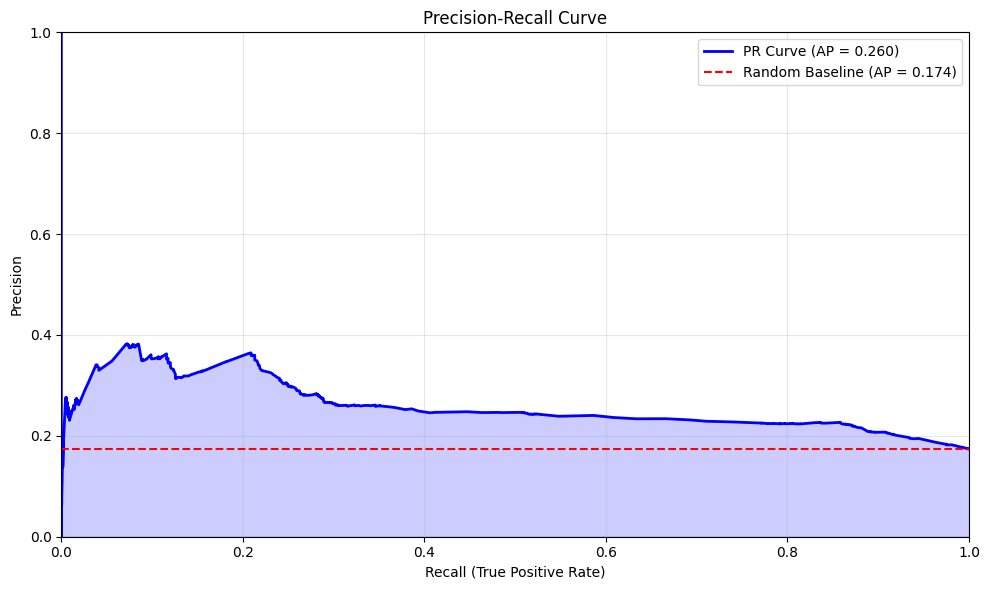


Optimal Threshold Analysis (maximizing F1-score):
Optimal threshold: 0.1262
Precision at optimal threshold: 0.2268
Recall at optimal threshold: 0.8581
F1-score at optimal threshold: 0.3588

Classification Report with Optimal Threshold (0.1262):
              precision    recall  f1-score   support

           0       0.93      0.38      0.54     11113
           1       0.23      0.86      0.36      2346

    accuracy                           0.47     13459
   macro avg       0.58      0.62      0.45     13459
weighted avg       0.81      0.47      0.51     13459



/tmp/ipykernel_947/2309881711.py:47: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])


In [72]:
# Precision-Recall Curve Analysis

import joblib
model_data = joblib.load('sgd_logistic_pyarrow_test.joblib')
clf = model_data['clf']
scaler = model_data['scaler']
feature_columns = model_data['feature_list']

# Calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Baseline = proportion of positive class 
baseline = (y_test == 1).mean()

print(f"Precision-Recall Analysis:")
print(f"Average Precision (AP): {average_precision:.4f}")
print(f"Baseline (random classifier): {baseline:.4f}")
print(f"Improvement over baseline: {average_precision/baseline:.2f}x")

# Precision-recall plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'PR Curve (AP = {average_precision:.3f})')
plt.fill_between(recall, precision, alpha=0.2, color='blue') #alpha - transparency

# Add baseline (random classifier)
plt.axhline(y=baseline, color='red', linestyle='--', 
           label=f'Random Baseline (AP = {baseline:.3f})')

# Visuals
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.tight_layout()
plt.show()




# Keeping the below for more quantifiable insight

# Find optimal threshold (maximize F1-score)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
# Handle division by zero
f1_scores = np.nan_to_num(f1_scores)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal Threshold Analysis (maximizing F1-score):")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Precision at optimal threshold: {optimal_precision:.4f}")
print(f"Recall at optimal threshold: {optimal_recall:.4f}")
print(f"F1-score at optimal threshold: {optimal_f1:.4f}")